In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import warnings
import warnings
warnings.filterwarnings("ignore")

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [6]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv('winequality-red.csv', delimiter=';')

1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [7]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [8]:
simple_tree = DecisionTreeClassifier()
cross_val_score(simple_tree, X, y, scoring='accuracy').mean()

0.48217868338558

In [9]:
bagging_tree = BaggingClassifier(n_estimators=100)
cross_val_score(bagging_tree, X, y, scoring='accuracy').mean()

0.5666065830721003

In [10]:
randomforest_tree = RandomForestClassifier(n_estimators=100)
cross_val_score(randomforest_tree, X, y, scoring='accuracy').mean()

0.5709815830721003

Случайный лес выигрывает, используя бэггинг и выбор лучших признаков при разбиении вершин

2.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [12]:
scores_acc = []
n_trees = np.hstack(([10,50,100,200], np.arange(200, 5001, 200)))
for n in tqdm(n_trees):
    randomforest_tree = RandomForestClassifier(n_estimators=n)
    randomforest_tree.fit(X_train, y_train)
    scores_acc.append(accuracy_score(y_test, randomforest_tree.predict(X_test)))

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [03:49<00:00,  7.92s/it]


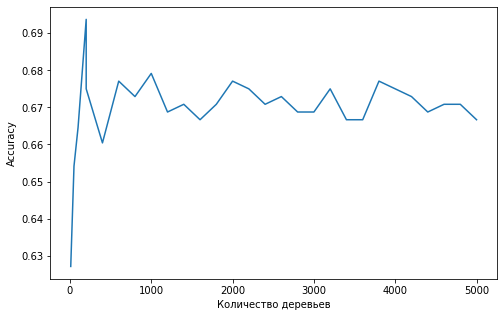

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Количество деревьев')
ax.set_ylabel('Accuracy')
ax.plot(n_trees, scores_acc);

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [14]:
gr_boosting = GradientBoostingClassifier()
cross_val_score(gr_boosting, X, y, scoring='accuracy').mean()

0.5647276645768025

In [24]:
xgboost = xgb.XGBClassifier(verbosity = 0)
cross_val_score(xgboost, X, y, scoring='accuracy').mean()

0.5472335423197492

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [30]:
params = {'loss' : ['deviance', 'exponential'],
          'learning_rate' : np.arange(0.1, 1, 0.3),
          'n_estimators' : [20,50,100,200],
          'max_depth' : [2,3,4,5]}

In [31]:
grid_gr_boosting = GridSearchCV(gr_boosting, params, scoring='accuracy', cv=3)
grid_gr_boosting.fit(X_train, y_train)
y_pred_gr_boosting = grid_gr_boosting.predict(X_test)
acc_gr_boosting = accuracy_score(y_test, y_pred_gr_boosting)
fit_time = np.mean(grid_gr_boosting.cv_results_['mean_fit_time'])
print(f'Accuracy метрика для GradientBoostingClassifier модели: {acc_gr_boosting},\n'
      f'параметры: {grid_gr_boosting.best_estimator_}\n'
      f'среднее время обучения: {fit_time}')

Accuracy метрика для GradientBoostingClassifier модели: 0.6520833333333333,
параметры: GradientBoostingClassifier(max_depth=5)
среднее время обучения: 0.7384084852205381


In [69]:
params = {'objective' : ['multi:softmax', 'multi:softprob'],
          'learning_rate' : np.arange(0.1, 1, 0.3),
          'n_estimators' : [20,50,100,200],
          'max_depth' : [2,3,4,5]}

In [70]:
grid_xgboost = GridSearchCV(xgboost, params, scoring='accuracy', cv=3)
grid_xgboost.fit(X_train, y_train)
y_pred_grid_xgboost = grid_xgboost.predict(X_test)
acc_grid_xgboost = accuracy_score(y_test, y_pred_grid_xgboost)
fit_time = np.mean(grid_xgboost.cv_results_['mean_fit_time'])
print(f'Accuracy метрика для XGBClassifier модели: {acc_grid_xgboost},\n'
      f'параметры: {grid_xgboost.best_estimator_},\n'
      f'среднее время обучения: {fit_time}')

Accuracy метрика для XGBClassifier модели: 0.66875,
параметры: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0),
среднее время обучения: 0.2393504223889775


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [40]:
lightgbm = lgb.LGBMClassifier()
cross_val_score(lightgbm, X, y, scoring='accuracy').mean()

0.5572472570532915

In [41]:
catboost = ctb.CatBoostClassifier(verbose=0)
cross_val_score(catboost, X, y, scoring='accuracy').mean()

0.5459757053291535

С параметрами по умолчаю лучше всего результат у GradientBoostingClassifier 0.5641026645768024

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [71]:
params = {'objective' : ['muticlass', 'multiclassova'],
          'learning_rate' : np.arange(0.1, 1, 0.3),
          'n_estimators' : [20,50,100,200],
          'max_depth' : [2,3,4,5]}

In [73]:
grid_lightgbm = GridSearchCV(lightgbm, params, scoring='accuracy', cv=3)
grid_lightgbm.fit(X_train, y_train)
y_pred_grid_lightgbm = grid_lightgbm.predict(X_test)
acc_grid_xgboost = accuracy_score(y_test, y_pred_grid_lightgbm)
fit_time = np.mean(grid_lightgbm.cv_results_['mean_fit_time'])
print(f'Accuracy метрика для XGBClassifier модели: {acc_grid_xgboost},\n'
      f'параметры: {grid_lightgbm.best_estimator_.get_params()},\n'
      f'среднее время обучения: {fit_time}')

Accuracy метрика для XGBClassifier модели: 0.6208333333333333,
параметры: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'multiclassova', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0},
среднее время обучения: 0.09266594466235904


In [57]:
params = {'objective' : ['MultiClass', 'MultiClassOneVsAll'],
          'learning_rate' : np.arange(0.1, 1, 0.3),
          'n_estimators' : [20,50,100,200],
          'max_depth' : [2,3,4,5]}

In [58]:
grid_catboost = GridSearchCV(catboost, params, scoring='accuracy', cv=3)
grid_catboost.fit(X_train, y_train)
y_pred_grid_catboost = grid_catboost.predict(X_test)
acc_grid_catboost = accuracy_score(y_test, y_pred_grid_catboost)
fit_time = np.mean(grid_catboost.cv_results_['mean_fit_time'])
print(f'Accuracy метрика для XGBClassifier модели: {acc_grid_catboost},\n'
      f'параметры: {grid_catboost.best_estimator_.get_params()},\n'
      f'среднее время обучения: {fit_time}')

Accuracy метрика для XGBClassifier модели: 0.6083333333333333,
параметры: {'learning_rate': 0.1, 'verbose': 0, 'max_depth': 5, 'n_estimators': 200, 'objective': 'MultiClassOneVsAll'},
среднее время обучения: 0.23892211582925585


Лучший результат у XGBClassifier : 0.66875

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [hyperopt](https://github.com/hyperopt/hyperopt) . Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [124]:
space_xgb = {'objective' : hp.choice('objective', ['multi:softmax', 'multi:softprob']),
          'learning_rate' : hp.choice('learning_rate', np.arange(0.1, 1, 0.3)),
          'n_estimators' : hp.choice('n_estimators', [20,50,100,200]),
          'max_depth' : hp.choice('max_depth', [2,3,4,5])}

In [127]:
def hyperopt_xgb_score(params):
    clf = xgb.XGBClassifier(scoring='accuracy', **params)
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score

In [128]:
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print(f'best: {best}')

0.5278298936835522                                                                                                     
{'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 50, 'objective': 'multi:softmax'}                               
0.5484677923702314                                                                                                     
{'learning_rate': 0.7000000000000001, 'max_depth': 4, 'n_estimators': 20, 'objective': 'multi:softmax'}                
0.5365853658536585                                                                                                     
{'learning_rate': 0.7000000000000001, 'max_depth': 4, 'n_estimators': 50, 'objective': 'multi:softmax'}                
0.5709818636647905                                                                                                     
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20, 'objective': 'multi:softmax'}                               
0.5084427767354597                      

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [144]:
estimators = [('cat', ctb.CatBoostClassifier()),
              ('lightgbm', lgb.LGBMClassifier()),
              ('gr', GradientBoostingClassifier())]

sclf = StackingClassifier(estimators= estimators , final_estimator=xgb.XGBClassifier())
cross_val_score(sclf, X, y, scoring='accuracy', cv=3, n_jobs=-1).mean()

0.5247029393370856

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [141]:
gr_params = grid_gr_boosting.best_estimator_.get_params()
xgboost_params = grid_xgboost.best_estimator_.get_params()
lightgbm_params = grid_lightgbm.best_estimator_.get_params()
catboost_params = grid_catboost.best_estimator_.get_params()

In [143]:
estimators = [('cat', ctb.CatBoostClassifier(**catboost_params)),
              ('lightgbm', lgb.LGBMClassifier(**lightgbm_params)),
              ('gr', GradientBoostingClassifier(**gr_params))]

sclf = StackingClassifier(estimators= estimators , final_estimator=xgb.XGBClassifier(**xgboost_params))
cross_val_score(sclf, X, y, scoring='accuracy', cv=3, n_jobs=-1).mean()

0.5553470919324578

Параметры при которых алгоритмы давали лучшие результаты дают прирост в стэкинге